In [1]:
# Import library utama
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import numpy as np
import zipfile
import os

In [2]:
from google.colab import files
import shutil

# Upload folder dataset (misalnya kamu pilih folder utama berisi dua folder gambar)
uploaded = files.upload()

# Jika dataset dikompres (zip), ekstrak dulu
for filename in uploaded.keys():
    if filename.endswith(".zip"):
        with zipfile.ZipFile(filename, 'r') as zip_ref:
            zip_ref.extractall("/content/dataset")
        print("Dataset berhasil diekstrak ke /content/dataset")

Saving DataSetDaun.zip to DataSetDaun.zip
Dataset berhasil diekstrak ke /content/dataset


In [3]:
# Lokasi dataset
data_dir = "/content/dataset/DataSetDaun"

# Gunakan ImageDataGenerator untuk augmentasi dan preprocessing MobileNetV2
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=0.2,        # 80% train, 20% validation
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True
)

train_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

val_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

Found 82 images belonging to 2 classes.
Found 20 images belonging to 2 classes.


In [4]:
# Load base model dari MobileNetV2 tanpa top layer
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224,224,3))

# Bekukan layer awal supaya tidak ikut dilatih (feature extractor)
base_model.trainable = False

# Tambahkan layer classifier di atasnya
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(train_generator.num_classes, activation='softmax')
])

# Compile model
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,422,210 (9.24 MB)

 Trainable params: 164,226 (641.51 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [5]:
# Latih model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,
    verbose=1
)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 17s 5s/step - accuracy: 0.3823 - loss: 1.4624 - val_accuracy: 0.4000 - val_loss: 1.0068
Epoch 2/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 8s 3s/step - accuracy: 0.3571 - loss: 1.3020 - val_accuracy: 0.4500 - val_loss: 0.7475
Epoch 3/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 9s 3s/step - accuracy: 0.4589 - loss: 0.9224 - val_accuracy: 0.5000 - val_loss: 0.6843
Epoch 4/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 8s 2s/step - accuracy: 0.5411 - loss: 0.7506 - val_accuracy: 0.6500 - val_loss: 0.6414
Epoch 5/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 8s 2s/step - accuracy: 0.5261 - loss: 0.8021 - val_accuracy: 0.9000 - val_loss: 0.4457
Epoch 6/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - accuracy: 0.6442 - loss: 0.6646 - val_accuracy: 0.8000 - val_loss: 0.4717
Epoch 7/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 8s 2s/step - accuracy: 0.7471 - loss: 0.5058 - val_accuracy: 0.8500 - val_loss: 0.4005
Epoch 8/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - accuracy: 0.8531 - loss: 0.3998 - val_accuracy: 0.9500 - val_loss: 0.3764
Epoch 9/10
3/3 

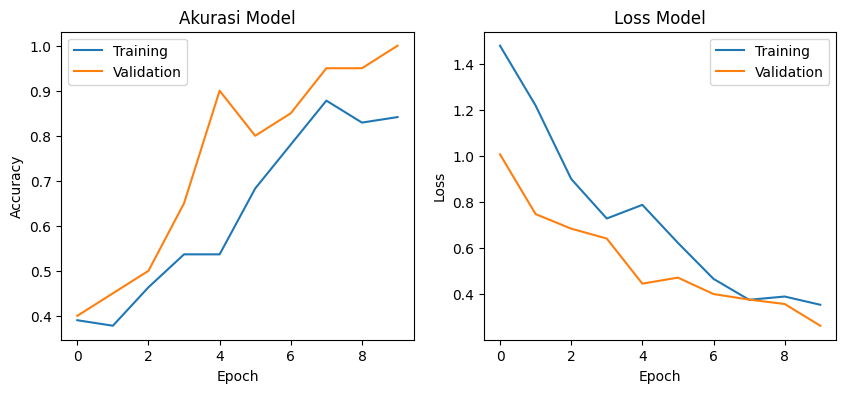

In [6]:
# Plot akurasi dan loss
plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Training')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Akurasi Model')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Training')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Loss Model')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [8]:
from tensorflow.keras.preprocessing import image

img_path = '/content/dataset/DataSetDaun/Daun Sirih/021.jpg'  # Corrected path
img = image.load_img(img_path, target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

pred = model.predict(x)
classes = list(train_generator.class_indices.keys())
print("Prediksi gambar ini adalah:", classes[np.argmax(pred)])

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Prediksi gambar ini adalah: Daun Sirih


In [9]:
# Unfreeze sebagian layer akhir
base_model.trainable = True
for layer in base_model.layers[:-30]:
    layer.trainable = False

# Compile ulang dengan learning rate kecil
model.compile(optimizer=Adam(learning_rate=1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Lanjutkan training
fine_tune = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=5,
    verbose=1
)

Epoch 1/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 24s 4s/step - accuracy: 0.7535 - loss: 0.5241 - val_accuracy: 1.0000 - val_loss: 0.2011
Epoch 2/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 8s 2s/step - accuracy: 0.8031 - loss: 0.4613 - val_accuracy: 0.9500 - val_loss: 0.2890
Epoch 3/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 11s 3s/step - accuracy: 0.7710 - loss: 0.4674 - val_accuracy: 0.9500 - val_loss: 0.2184
Epoch 4/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 9s 4s/step - accuracy: 0.8385 - loss: 0.3448 - val_accuracy: 1.0000 - val_loss: 0.2694
Epoch 5/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 9s 3s/step - accuracy: 0.8485 - loss: 0.3115 - val_accuracy: 1.0000 - val_loss: 0.2420


In [10]:
model.save('/content/model_mobilenetv2_herbal.h5')
print("Model tersimpan!")

Model tersimpan!


Saving 001.jpg to 001.jpg
Saving 002.jpg to 002.jpg
Saving 003.jpg to 003.jpg
Saving 004.jpg to 004.jpg
Saving 005.jpg to 005 (1).jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


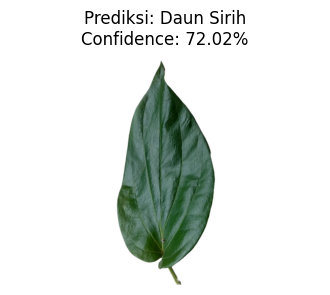

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


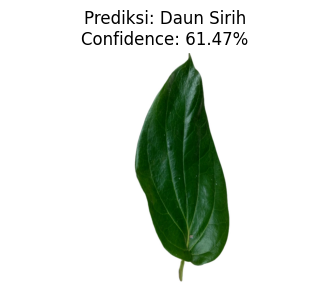

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


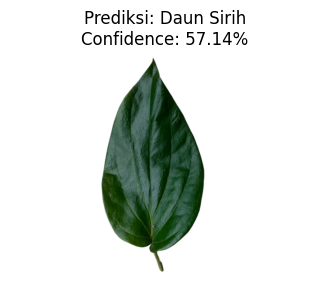

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


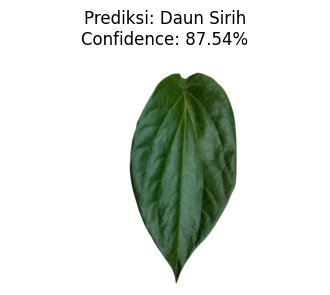

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


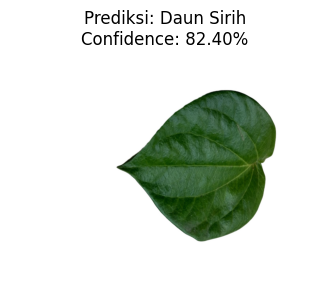

In [15]:
from google.colab import files
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt

# Upload satu atau beberapa gambar
uploaded = files.upload()

# Loop untuk setiap gambar yang diupload
for fn in uploaded.keys():
    path = fn

    # Load dan preprocess gambar
    img = image.load_img(path, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)

    # Prediksi dengan model
    pred = model.predict(x)
    classes = list(train_generator.class_indices.keys())
    pred_label = classes[np.argmax(pred)]
    confidence = np.max(pred) * 100  # ambil nilai tertinggi dari probabilitas

    # Tampilkan hasil prediksi
    plt.figure(figsize=(4,4))
    plt.imshow(image.load_img(path))
    plt.axis('off')
    plt.title(f"Prediksi: {pred_label}\nConfidence: {confidence:.2f}%")
    plt.show()

In [16]:
import pandas as pd

results = []

for fn in uploaded.keys():
    path = fn
    img = image.load_img(path, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)

    pred = model.predict(x)
    classes = list(train_generator.class_indices.keys())
    pred_label = classes[np.argmax(pred)]
    confidence = np.max(pred) * 100

    results.append({'filename': fn, 'predicted_label': pred_label, 'confidence': confidence})

# Simpan hasil prediksi ke file CSV
df = pd.DataFrame(results)
df.to_csv('hasil_prediksi.csv', index=False)
print("Hasil prediksi disimpan ke hasil_prediksi.csv")
df

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
Hasil prediksi disimpan ke hasil_prediksi.csv


,filename,predicted_label,confidence
0,001.jpg,Daun Sirih,72.015800
1,002.jpg,Daun Sirih,61.468651
2,003.jpg,Daun Sirih,57.142895
3,004.jpg,Daun Sirih,87.540985
4,005 (1).jpg,Daun Sirih,82.398361


In [17]:
from google.colab import sheets
sheet = sheets.InteractiveSheet(df=df)

https://docs.google.com/spreadsheets/d/1PXz2nmca98R65oBSMWnHIJdUq1ROx6RdkJVEbsvCgdk/edit#gid=0
